In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

print(bool(os.getenv("OPENAI_API_KEY")))

True


In [2]:
import PyPDF2

# Open the PDF file
with open('../data/coffee_processing.pdf', 'rb') as file:
    # Create a PDF reader object
    pdf_reader = PyPDF2.PdfReader(file)
    
    # Get the number of pages
    num_pages = len(pdf_reader.pages)
    print(f"Total pages: {num_pages}")
    
    # Initialize variable to store all text
    all_text = []
    
    # Extract text from all pages
    for page_num in range(num_pages):
        page = pdf_reader.pages[page_num]
        text = page.extract_text()
        if text:  # Only add if page has text
            all_text.append(text.strip())
    
    # Combine all text with double newline between pages
    text_document = "\n\n".join(all_text)

    text_document = text_document.replace("Explore our developer-friendly HTML  to PDF API Printed using PDFCrowd HTML  to PDF", "")
    
    # Print the combined text
    print("\n=== COMBINED TEXT ===\n")
    print(text_document)
    
    # Optionally print stats
    print(f"\n\nTotal characters: {len(text_document)}")

Total pages: 4

=== COMBINED TEXT ===

Coffee Processing Methods
A Comprehensive Guide to Post-Harvest Coffee Processing
Coffee processing began in Ethiopia over 1,000 years ago.
Introduction to Coffee Processing
Coffee processing is the method used to transform freshly picked coffee cherries into green coffee
beans ready for roasting. The processing method significantly impacts the final flavor profile of the
coffee. Different regions around the world have developed unique processing techniques based on
their climate, available resources, and traditional practices. The choice of processing method can
enhance certain flavor characteristics while suppressing others, making it one of the most critical
decisions in coffee production.
Processing begins immediately after harvest, as coffee cherries are highly perishable. The outer
fruit must be removed, and the beans must be dried to prevent spoilage. The manner in which this
is accomplished varies widely, from ancient sun-drying methods to

In [3]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    separators=[".", "\n\n"],
    chunk_size=400,
    chunk_overlap=40
)
chunks = text_splitter.create_documents([text_document])

print(f'Total no of chunks: {len(chunks)}', end='\n')

for chunk in chunks:
    print(chunk.page_content)
    print('-'*20)


Total no of chunks: 17
Coffee Processing Methods
A Comprehensive Guide to Post-Harvest Coffee Processing
Coffee processing began in Ethiopia over 1,000 years ago.
Introduction to Coffee Processing
Coffee processing is the method used to transform freshly picked coffee cherries into green coffee
beans ready for roasting. The processing method significantly impacts the final flavor profile of the
coffee
--------------------
. Different regions around the world have developed unique processing techniques based on
their climate, available resources, and traditional practices. The choice of processing method can
enhance certain flavor characteristics while suppressing others, making it one of the most critical
decisions in coffee production
--------------------
.
Processing begins immediately after harvest, as coffee cherries are highly perishable. The outer
fruit must be removed, and the beans must be dried to prevent spoilage. The manner in which this
is accomplished varies widely, from a

In [4]:
from langchain_openai import OpenAIEmbeddings
import chromadb

# Initialize embeddings model
embeddings_model = OpenAIEmbeddings(model="text-embedding-3-small")

# Set up ChromaDB client with persistent storage
chroma_client = chromadb.PersistentClient(path="../chroma_db")


In [8]:
collection = chroma_client.get_collection(name="my_documents_recursive_chunking")
print(collection.count())

17


In [5]:
# Delete existing collection if it exists (truncate)
try:
    chroma_client.delete_collection(name="my_documents_recursive_chunking")
    print("Existing collection deleted")
except:
    print("No existing collection found")

# Create new collection
collection = chroma_client.create_collection(
    name="my_documents_recursive_chunking",
    metadata={"description": "Document embeddings collection"}
)

No existing collection found


In [6]:
# Calculate embeddings in batches and prepare data
documents = []
embeddings_list = []
ids = []

# Extract all texts first
all_texts = []
for idx, chunk in enumerate(chunks):
    text = chunk["page_content"] if isinstance(chunk, dict) else chunk.page_content
    all_texts.append(text)
    ids.append(f"doc_{idx}")

# Calculate embeddings in batches
batch_size = 100  # Adjust based on your needs and API limits
total_batches = (len(all_texts) + batch_size - 1) // batch_size

print(f"Processing {len(all_texts)} documents in {total_batches} batches...")

for i in range(0, len(all_texts), batch_size):
    batch_texts = all_texts[i:i + batch_size]
    
    # Calculate embeddings for the batch
    batch_embeddings = embeddings_model.embed_documents(batch_texts)
    
    # Add to main lists
    documents.extend(batch_texts)
    embeddings_list.extend(batch_embeddings)
    
    batch_num = (i // batch_size) + 1
    print(f"Processed batch {batch_num}/{total_batches} ({len(batch_texts)} documents)")

print(f"\nTotal embeddings calculated: {len(embeddings_list)}")

# Insert all data into ChromaDB
collection.add(
    documents=documents,
    embeddings=embeddings_list,
    ids=ids
)

print(f"Successfully added {len(documents)} documents to ChromaDB")

Processing 17 documents in 1 batches...
Processed batch 1/1 (17 documents)

Total embeddings calculated: 17
Successfully added 17 documents to ChromaDB


In [7]:
# Perform similarity search
query = """What are the environmental concerns and solutions related to coffee processing"""

# Calculate query embedding
query_embedding = embeddings_model.embed_query(query)

# Search for top K similar documents
k = 10  # Number of results to return

results = collection.query(
    query_embeddings=[query_embedding],
    n_results=k
)

# Print results
print(f"Query: '{query}'\n")
print(f"Top {k} similar documents:\n")
print("=" * 80)

for i in range(len(results['ids'][0])):
    distance = results['distances'][0][i]
    
    # Correct conversion: cosine similarity = 1 - cosine distance
    # Then convert to percentage
    cosine_similarity = 1 - distance
    confidence_percentage = cosine_similarity * 100
    
    print(f"\nRank {i + 1}:")
    print(f"ID: {results['ids'][0][i]}")
    print(f"Raw Text: {results['documents'][0][i]}")
    print(f"Cosine Distance: {distance:.4f}")
    print(f"Cosine Similarity: {cosine_similarity:.4f}")
    print(f"Confidence: {confidence_percentage:.2f}%")
    print("-" * 80)

Query: 'What are the environmental concerns and solutions related to coffee processing'

Top 10 similar documents:


Rank 1:
ID: doc_3
Raw Text: .
Each method requires different amounts of water, time, and labor, which influences both the cost
of production and the environmental impact of coffee farming.
The global coffee industry processes approximately 10 million tons of coffee cherries annually, with
processing methods varying by region and producer size
Cosine Distance: 0.7804
Cosine Similarity: 0.2196
Confidence: 21.96%
--------------------------------------------------------------------------------

Rank 2:
ID: doc_1
Raw Text: . Different regions around the world have developed unique processing techniques based on
their climate, available resources, and traditional practices. The choice of processing method can
enhance certain flavor characteristics while suppressing others, making it one of the most critical
decisions in coffee production
Cosine Distance: 0.8134
Cosine Similari

In [9]:
import numpy as np

# Fetch all embeddings + metadata
data = collection.get(
    include=["embeddings", "documents", "metadatas"]
)

embeddings = np.array(data["embeddings"])
documents = data["documents"]


In [10]:
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances

cosine_dist = cosine_distances(embeddings)
euclid_dist = euclidean_distances(embeddings)

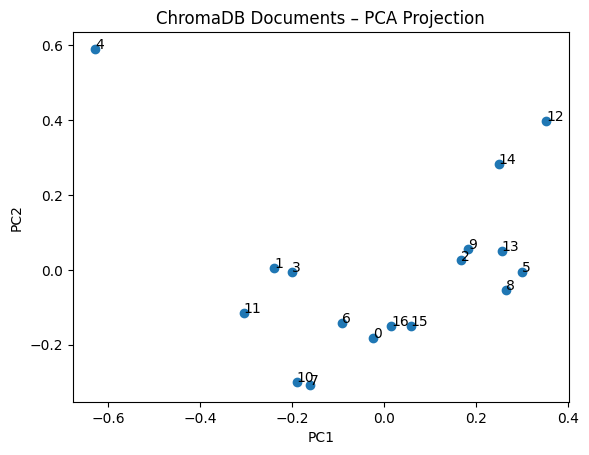

In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
points_2d = pca.fit_transform(embeddings)

plt.figure()
plt.scatter(points_2d[:, 0], points_2d[:, 1])

for i, doc in enumerate(documents):
    plt.annotate(str(i), (points_2d[i, 0], points_2d[i, 1]))

plt.title("ChromaDB Documents – PCA Projection")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


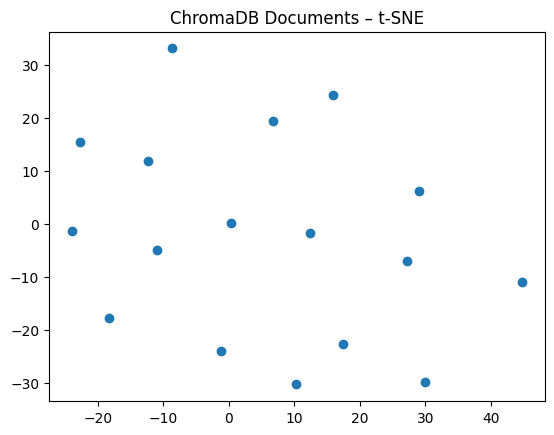

In [13]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=10, random_state=42)
points_2d = tsne.fit_transform(embeddings)

plt.figure()
plt.scatter(points_2d[:, 0], points_2d[:, 1])
plt.title("ChromaDB Documents – t-SNE")
plt.show()
